In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Show some training images:

In [3]:
import matplotlib.pyplot as plt
import numpy as np

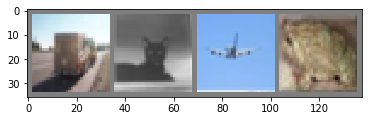

truck   cat plane  frog


In [4]:
def imshow(img):
    img = img /2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '. join('%5s' % classes[labels[j]] for j in range(4)))

Define a neural network

In [5]:
import torch.nn as nn
import torch.nn.functional as F

In [6]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

Define a Loss function and optimizer

Use a Classification Cross-Entropy loss and SGD with momentum

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Train the Network
Loop over data iterator and feed inputs to the network and optimize

In [8]:
for epoch in range(4):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        #Get the inputs: data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss/2000))
            running_loss = 0.0
            
print('Finished training')

[1,  2000] loss: 2.242
[1,  4000] loss: 1.958
[1,  6000] loss: 1.737
[1,  8000] loss: 1.610
[1, 10000] loss: 1.538
[1, 12000] loss: 1.506
[2,  2000] loss: 1.416
[2,  4000] loss: 1.418
[2,  6000] loss: 1.366
[2,  8000] loss: 1.314
[2, 10000] loss: 1.314
[2, 12000] loss: 1.276
[3,  2000] loss: 1.204
[3,  4000] loss: 1.189
[3,  6000] loss: 1.201
[3,  8000] loss: 1.167
[3, 10000] loss: 1.186
[3, 12000] loss: 1.163
[4,  2000] loss: 1.078
[4,  4000] loss: 1.098
[4,  6000] loss: 1.099
[4,  8000] loss: 1.096
[4, 10000] loss: 1.055
[4, 12000] loss: 1.086
Finished training


Save the trained model

In [9]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Test the network on test data

In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('groundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

groundTruth:    cat  ship  ship plane


Load the saved model

In [11]:
net = Net()
net.load_state_dict(torch.load(PATH))

In [12]:
outputs = net(images)

In [13]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car plane plane


In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 60 %


In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 68 %
Accuracy of   car : 75 %
Accuracy of  bird : 57 %
Accuracy of   cat : 38 %
Accuracy of  deer : 35 %
Accuracy of   dog : 54 %
Accuracy of  frog : 71 %
Accuracy of horse : 66 %
Accuracy of  ship : 71 %
Accuracy of truck : 68 %
